1. ensure dependencies

In [1]:
import sys
import os
from pathlib import Path

# Set project root
current_dir = Path(os.getcwd())
if (current_dir / 'shared').exists():
    project_root = str(current_dir)
elif (current_dir.parent / 'shared').exists():
    project_root = str(current_dir.parent)
else:
    project_root = "C:/ComfyUI/trainer"

if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root set to: {project_root}")

Project root set to: c:\ComfyUI\trainer


2. main train

In [2]:
# Data Loading & Filtering (Cached to Disk)
import importlib
import training.data_utils
importlib.reload(training.data_utils)
from training.data_utils import get_filtered_data
from training.helpers import resolve_path
from shared.config import config

vectors_path = resolve_path(config["vectors_file"])
scores_path = resolve_path(config["scores_file"])

X_filtered, y_filtered, kept_features, interaction_indices = get_filtered_data(
    vectors_path, 
    scores_path
)

print(f"Data ready. Filtered shape: {X_filtered.shape} (from {len(kept_features)} features)")
print(f"Interactions: {len(interaction_indices)} selected")

Cache not found or invalid. Building processed dataset...
Filtering features... Initial shape: (7022, 2327)


Training LightGBM:  99%|█████████▉| 99/100 [00:08<00:00, 15.27it/s]

Dropped 988 unused features. New shape: (7022, 1339)


Training LightGBM: 100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


Saved filtered data to cache: C:\ComfyUI\trainer\training\output\filtered_data_cache.npz
Generating top interaction features...
Scanning 895791 potential interactions in batches of 598...


Computing Correlations: 100%|██████████| 7022/7022 [00:48<00:00, 143.53samples/s]


Selecting top 500 interaction features...


Building Interaction Matrix: 100%|██████████| 7022/7022 [00:14<00:00, 489.80samples/s]


Saved interaction data to cache: C:\ComfyUI\trainer\training\output\interaction_data_cache.npz
Saved processed data to cache: C:\ComfyUI\trainer\training\output\processed_data_cache.npz
Data ready. Filtered shape: (7022, 1839) (from 1339 features)
Interactions: 500 selected


Training LightGBM: 100%|██████████| 1620/1620 [00:35<00:00, 45.59it/s] 


Saved joblib model to: c:\ComfyUI\trainer\training\output\model.joblib
Saved ONNX model to: c:\ComfyUI\trainer\training\output\model.onnx
metrics: {'r2': 0.44290144220743255, 'mae': 0.8266364286545825, 'mse': 1.046133179199745, 'rmse': 1.0228065209020447, 'model_type': 'LGBMRegressor', 'training_time': 35.53188920021057, 'n_iter': 1620, 'target_transform_lambdas': array([0.74089105]), 'target_transform_mean': array([2.23851052]), 'target_transform_scale': array([0.98375414]), 'loss_curve': [np.float64(0.9934867583953386), np.float64(0.9896447337306385), np.float64(0.9861191902593267), np.float64(0.9828024411919074), np.float64(0.9795147774676021), np.float64(0.9763240272420859), np.float64(0.9728450671626221), np.float64(0.9695102179742221), np.float64(0.9664171678797301), np.float64(0.9630166652952757), np.float64(0.9600894013105379), np.float64(0.9572425916487661), np.float64(0.9540527335797209), np.float64(0.9507777690659994), np.float64(0.9474433499486645), np.float64(0.94444290687

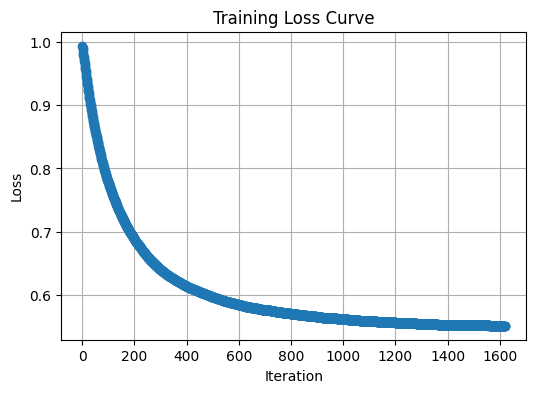

Saved model diagnostics keys: ['r2', 'mae', 'mse', 'rmse', 'model_type', 'training_time', 'n_iter', 'target_transform_lambdas', 'target_transform_mean', 'target_transform_scale', 'loss_curve', 'loss_curve_length', 'has_loss_curve', 'has_n_iter']
  loss_curve (first 10): [0.99348676 0.98964473 0.98611919 0.98280244 0.97951478 0.97632403
 0.97284507 0.96951022 0.96641717 0.96301667]
  saved n_iter: 1620


In [3]:
# DO NOT DELETE THIS LINES
# the main code for training the onnx classifier
# this uses the ouput for the previous step, /prepare/output/ vectors,scores
# then run the method, and print the progress during training
# then show the final evaluation results: r2, mae, mse, rmse

import json
import warnings
from sklearn.exceptions import ConvergenceWarning
import shared.config
import importlib

# Force reload config to pick up file changes
importlib.reload(shared.config)
from shared.config import config

from training.helpers import resolve_path
import training.run as tr
import training.model_io

importlib.reload(training.model_io)
from training.model_io import save_model

importlib.reload(tr)

# Ensure ConvergenceWarnings are visible in the notebook cell output
warnings.filterwarnings("default", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")

import os
import numpy as np

training_cfg = config["training"]
training_out = training_cfg["output_dir"]
model_path = os.path.join(resolve_path(training_out), "model")

config_selection = "top"

current_config = training_cfg[config_selection]

# Ensure data is ready (from previous cell)
if "X_filtered" not in locals():
    raise RuntimeError("Data not found. Please run the data loading cell above.")

model, metrics = tr.train_model(
    model_path=model_path,
    config_dict=current_config,
    X=X_filtered,
    y=y_filtered,
    kept_features=kept_features,
)

score = float(metrics["r2"])
training_time = float(metrics["training_time"])
new_config = {
    **current_config,
    "best_score": score,
    "training_time": training_time,
}
config["training"][config_selection].update(new_config)

save_model(model, model_path, additional_data=metrics)

print(f"metrics: {metrics}")

# Print metrics like run_training did
print("Training complete. Evaluation metrics:")
for k, v in metrics.items():
    try:
        print(f"  {k}: {v:.4f}")
    except Exception:
        print("  {}: {}".format(k, v))

# Friendly post-training suggestion when no diagnostics available
if not metrics.get("has_loss_curve") and not metrics.get("has_n_iter"):
    print(
        "Warning: No training iterations or loss curve were recorded. Consider increasing 'epochs' or using solver='adam' with verbose=True to collect diagnostics."
    )

# Plot loss curve if available
try:
    tr.plot_loss_curve(model_path, metrics)
except Exception as e:
    print("Could not plot loss curve:", e)

# Try loading saved model diagnostics from the .npz file for more detail
try:
    data = np.load(model_path + ".npz", allow_pickle=True)
    print("Saved model diagnostics keys:", list(data.keys()))
    if "params" in data:
        try:
            raw = data["params"]
            try:
                import numpy as _np

                if isinstance(raw, _np.ndarray) and raw.shape == ():
                    raw = raw.item()
            except Exception:
                pass
            if isinstance(raw, bytes):
                raw = raw.decode("utf-8")
            if isinstance(raw, str):
                try:
                    params = json.loads(raw)
                except Exception:
                    try:
                        params = eval(raw)
                    except Exception:
                        params = raw
            else:
                params = raw
            print("  saved params:", params)
        except Exception as e:
            print("  Could not parse saved params:", e, data.get("params"))
    # Metrics/loss info may be stored under 'metrics' or top-level keys
    try:
        metrics_blob = None
        if "metrics" in data:
            metrics_blob = data["metrics"]
            try:
                import numpy as _np

                if isinstance(metrics_blob, _np.ndarray) and metrics_blob.shape == ():
                    metrics_blob = metrics_blob.item()
            except Exception:
                pass
        if (
            metrics_blob is not None
            and isinstance(metrics_blob, dict)
            and "loss_curve" in metrics_blob
        ):
            lc = np.asarray(metrics_blob["loss_curve"])
            if lc.size > 0:
                print("  loss_curve (first 10):", lc[:10])
            else:
                print("  loss_curve present but empty")
        elif "loss_curve" in data:
            lc = np.asarray(data["loss_curve"])
            if lc.size > 0:
                print("  loss_curve (first 10):", lc[:10])
    except Exception as e:
        print("  Could not read loss_curve:", e)
    try:
        if (
            metrics_blob is not None
            and isinstance(metrics_blob, dict)
            and "n_iter" in metrics_blob
        ):
            print("  saved n_iter:", int(metrics_blob["n_iter"]))
        elif "n_iter" in data:
            print("  saved n_iter:", int(data["n_iter"]))
    except Exception:
        pass
except Exception as e:
    print("Could not load saved model diagnostics:", e)

In [4]:
import training.run as tr
print('training.run file:', tr.__file__)


training.run file: c:\ComfyUI\trainer\training\run.py


3. compare with real data

Loading processed data from cache: C:\ComfyUI\trainer\training\output\processed_data_cache.npz
Data ready (cached). Shape: (7022, 1839)
Loading trained model from: c:\ComfyUI\trainer\training\output\model.onnx
Comparison metrics (sample): r2=0.7980, n=100


c:\ComfyUI\trainer\.venv\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


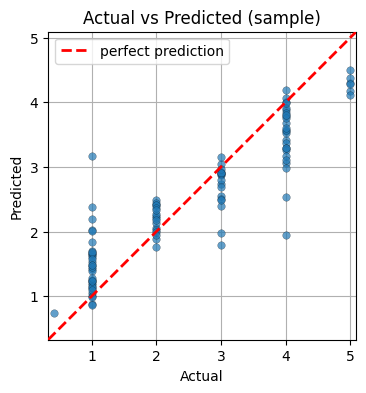

In [5]:
# DO NOT DELETE THESE LINES
# This cell compares the trained model vs data and produces a scatter plot.

import importlib
try:
    import training.data_utils
    importlib.reload(training.data_utils)
    import training.run as tr
    importlib.reload(tr)
    from training.run import compare_model_vs_data
    try:
        compare_model_vs_data(model_path, vectors_path, scores_path)
    except Exception as e:
        print("Comparison failed:", e)
        import traceback
        traceback.print_exc()
        print("Ensure vectors and scores files exist and are valid; function will fallback to a synthetic dataset if needed.")
except Exception as e:
    print('Could not import or reload training.run:', e)